In [56]:
import torch
import torch.nn.functional as F
import random

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [58]:
words = open('../names.txt').read().split()

In [59]:
stoi = {s: i+1 for i, s in enumerate(sorted(set(''.join(words))))}
stoi['.'] = 0
itos = {s: i for i, s in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [60]:

def build_dataset(words: list[str]):
    X, Y = [], []
    context_size = 3
    for w in words:
        context = [0] * context_size
        for ch in w + ".":
            X.append(context)
            Y.append(stoi[ch])
            # output = [itos[i] for i in context]
            # print(f"{''.join(output)} ----> {ch}")
            context = context[1:] + [stoi[ch]]
    return torch.tensor(X), torch.tensor(Y)


n1, n2 = int(0.8 * len(words)), int(0.9 * len(words))
random.shuffle(words)

X_train, Y_train = build_dataset(words=words[:n1])
X_dev, Y_dev = build_dataset(words=words[n1:n2])
X_test, Y_test = build_dataset(words=words[n2:])

X_train, Y_train = X_train.to(device=device), Y_train.to(device=device)
X_dev, Y_dev = X_dev.to(device=device), Y_dev.to(device=device)
X_test, Y_test = X_test.to(device=device), Y_test.to(device=device)

X_train.shape, X_dev.shape, X_test.shape

(torch.Size([182625, 3]), torch.Size([22791, 3]), torch.Size([22730, 3]))

In [61]:
g = torch.Generator(device=device).manual_seed(42)

In [72]:
C = torch.rand((27, 3), generator=g, device=device)
emb = C[X_train]
emb.shape

torch.Size([182625, 3, 3])

In [82]:
C = torch.rand((27, 5), generator=g, device=device)
W1 = torch.rand((15, 200), generator=g, device=device)
b1 = torch.rand(200, generator=g, device=device)
W2 = torch.rand((200, 27), generator=g, device=device)
b2 = torch.rand(27, generator=g, device=device)
parameters = [C, W1, b1, W2, b2]

In [83]:
sum(p.nelement() for p in parameters)

8762

In [84]:

for p in parameters:

    p.requires_grad = True

In [85]:
def forward(inputs):
    emb = C[inputs]
    h = torch.tanh(emb.view(-1, 15) @ W1+b1)
    logits = h @ W2 + b2
    return logits

In [86]:
n_iter = 10000
lre = torch.linspace(-3, 0, n_iter, device=device)
lrs = 10**lre
lrs[5000]

tensor(0.0316, device='cuda:0')

In [87]:
stepi, lossi, lossd = [], [], []

In [94]:
n_iter = 200000
lre = torch.linspace(-3, 0, n_iter)
lrs = 10**lre

for i in range(n_iter + 1):

    # minibatch
    ix = torch.randint(0, X_train.shape[0], (32,), device=device)

    # emb = C[]
    inputs = X_train[ix]
    targets_training = Y_train[ix]
    logits_train = forward(inputs)
    loss_train = F.cross_entropy(logits_train, targets_training)

    logits_dev = forward(X_dev)
    loss_dev = F.cross_entropy(logits_dev, Y_dev)

    if i % 10000 == 0:
        print(f"step {i}  train loss: {
              loss_train:.4f}  dev loss: {loss_dev:.4f} ")

    for p in parameters:
        p.grad = None
    loss_train.backward()

    # updating gradient
    # lr = lrs[i] if i < 100000 else 0.0001
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    stepi.append(i)
    lossi.append(loss_train.log10().item())
    lossd.append(loss_dev.log10().item())

step 0  train loss: 2.0497  dev loss: 2.1379 
step 10000  train loss: 2.2873  dev loss: 2.2228 
step 20000  train loss: 2.0636  dev loss: 2.2278 
step 30000  train loss: 2.3708  dev loss: 2.2315 
step 40000  train loss: 2.0545  dev loss: 2.2103 
step 50000  train loss: 1.8807  dev loss: 2.2209 
step 60000  train loss: 2.3606  dev loss: 2.2314 
step 70000  train loss: 2.3732  dev loss: 2.2318 
step 80000  train loss: 2.4695  dev loss: 2.2430 
step 90000  train loss: 2.2747  dev loss: 2.2293 
step 100000  train loss: 2.1047  dev loss: 2.2125 
step 110000  train loss: 2.0691  dev loss: 2.1358 
step 120000  train loss: 1.9769  dev loss: 2.1342 
step 130000  train loss: 1.9326  dev loss: 2.1338 
step 140000  train loss: 1.7681  dev loss: 2.1325 
step 150000  train loss: 1.7894  dev loss: 2.1341 
step 160000  train loss: 1.8330  dev loss: 2.1355 
step 170000  train loss: 1.9121  dev loss: 2.1312 
step 180000  train loss: 2.0039  dev loss: 2.1337 
step 190000  train loss: 1.9699  dev loss: 2.

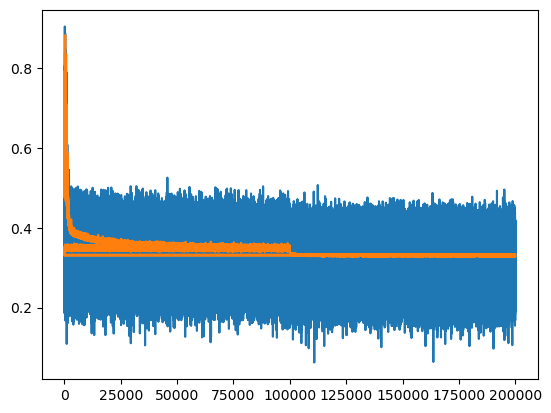

In [95]:
import matplotlib.pyplot as plt
plt.plot(stepi, lossi)
plt.plot(stepi, lossd)
plt.show()

In [96]:
# expl_count = 5
# for i in range(expl_count):
#     # context = [0] * 3